In [1]:
import random
import numpy as np

# Set a fixed random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)


In [2]:
import random
import numpy as np
from collections import deque

# Set a fixed random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


class GridWorld:
    ACTIONS = {
        0: (-1, 0),  # UP
        1: (1, 0),   # DOWN
        2: (0, -1),  # LEFT
        3: (0, 1)    # RIGHT
    }
    ACTION_NAMES = {0: "UP", 1: "DOWN", 2: "LEFT", 3: "RIGHT"}
    ACTION_ARROWS = {0: "↑", 1: "↓", 2: "←", 3: "→"}

    def __init__(
        self, 
        height=5, 
        width=5, 
        start=(0, 0), 
        goals=[(4, 4)], 
        obstacles=[(2, 2)], 
        step_penalty=-1, 
        goal_reward=5, 
        obstacle_reward=-5, 
        gamma=0.8,
        goal_dynamic=False,
        obstacle_dynamic=False,          
        n_dynamic_obstacles=1,
        n_dynamic_goals=1
    ):
        self.height = height
        self.width = width
        self.start = start
        self.initial_goals = goals.copy()
        self.initial_obstacles = obstacles.copy()
        self.goals = goals
        self.obstacles = obstacles
        self.step_penalty = step_penalty
        self.goal_reward = goal_reward
        self.obstacle_reward = obstacle_reward
        self.gamma = gamma
        self.goal_dynamic = goal_dynamic
        self.obstacle_dynamic = obstacle_dynamic
        self.n_dynamic_obstacles = n_dynamic_obstacles
        self.n_dynamic_goals = n_dynamic_goals

    def _update_dynamic_obstacles(self):
        """Randomly move obstacles if obstacle_dynamic=True."""
        all_cells = [(r, c) for r in range(self.height) for c in range(self.width)]
        valid_cells = [cell for cell in all_cells if cell not in self.goals and cell != self.start]
        self.obstacles = random.sample(valid_cells, min(self.n_dynamic_obstacles, len(valid_cells)))

    def _update_dynamic_goals(self):
        """Randomly move goals if goal_dynamic=True."""
        all_cells = [(r, c) for r in range(self.height) for c in range(self.width)]
        valid_cells = [cell for cell in all_cells if cell not in self.obstacles and cell != self.start]
        self.goals = random.sample(valid_cells, min(self.n_dynamic_goals, len(valid_cells)))

    def state_index(self, row, col):
        return row * self.width + col

    def state_coords(self, state):
        return divmod(state, self.width)

    def random_policy(self):
        policy = {}
        for s in range(self.width * self.height):
            policy[s] = {a: 1.0 / len(self.ACTIONS) for a in self.ACTIONS}
        return policy

    def reward(self, state):
        row, col = self.state_coords(state)
        if (row, col) in self.goals:
            return self.goal_reward
        elif (row, col) in self.obstacles:
            return self.obstacle_reward
        else:
            return self.step_penalty

    def step(self, state, action):
        row, col = self.state_coords(state)
        dr, dc = self.ACTIONS[action]

        nr, nc = row + dr, col + dc
        nr = max(0, min(self.height - 1, nr))
        nc = max(0, min(self.width - 1, nc))

        if (nr, nc) in self.obstacles:
            nr, nc = row, col

        next_state = self.state_index(nr, nc)
        reward = self.reward(next_state)
        done = (nr, nc) in self.goals
        return next_state, reward, done

    def deterministic_policy(self, stochastic_policy):
        policy = {}
        rewards = {}

        for s in range(self.width * self.height):
            max_prob = max(stochastic_policy[s].values())
            best_actions = [a for a, p in stochastic_policy[s].items() if abs(p - max_prob) < 1e-8]
            chosen_action = random.choice(best_actions)
            policy[s] = {a: 1.0 if a == chosen_action else 0.0 for a in self.ACTIONS}
            rewards[s] = self.reward(s)

        return policy, rewards

    def run_episode(self, policy, max_steps=50):
        if self.obstacle_dynamic:
            self._update_dynamic_obstacles()
        if self.goal_dynamic:
            self._update_dynamic_goals()

        state = self.state_index(*self.start)
        trajectory = [state]
        rewards = [0]
        total_reward = 0
        discount = 1.0

        for _ in range(max_steps):
            action = max(policy[state], key=policy[state].get)
            next_state, r, done = self.step(state, action)
            total_reward += discount * r
            discount *= self.gamma
            trajectory.append(next_state)
            rewards.append(total_reward)
            state = next_state
            if done:
                break

        return trajectory, rewards

    def visualise_episode(self, policy, cols=5):
        trajectory, rewards = self.run_episode(policy)
        n_steps = len(trajectory)
        rows = (n_steps + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
        axes = axes.flatten() if isinstance(axes, (list, np.ndarray)) else [axes]

        for i in range(n_steps):
            ax = axes[i]
            for x in range(self.width + 1):
                ax.plot([x, x], [0, self.height], color="black")
            for y in range(self.height + 1):
                ax.plot([0, self.width], [y, y], color="black")

            sr, sc = self.start
            ax.text(sc + 0.5, self.height - sr - 0.5, "S", ha="center", va="center",
                    fontsize=14, color="blue", fontweight="bold")

            for gr, gc in self.goals:
                ax.text(gc + 0.5, self.height - gr - 0.5, "G", ha="center", va="center",
                        fontsize=14, color="red", fontweight="bold")

            for orr, occ in self.obstacles:
                ax.text(occ + 0.5, self.height - orr - 0.5, "X", ha="center", va="center",
                        fontsize=14, color="black", fontweight="bold")

            row, col = self.state_coords(trajectory[i])
            ax.plot(col + 0.5, self.height - row - 0.5, "go", markersize=12)

            ax.set_title(f"Step {i}\nReward={rewards[i]:.1f}")
            ax.set_xlim(0, self.width)
            ax.set_ylim(0, self.height)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect("equal")

        for j in range(n_steps, len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()

    def visualise_policy(self, policy, title="Policy"):
        fig, ax = plt.subplots(figsize=(self.width, self.height))
        for x in range(self.width + 1):
            ax.plot([x, x], [0, self.height], color="black")
        for y in range(self.height + 1):
            ax.plot([0, self.width], [y, y], color="black")

        for row in range(self.height):
            for col in range(self.width):
                s = self.state_index(row, col)
                x, y = col + 0.5, self.height - row - 0.5

                if (row, col) in self.goals:
                    ax.text(x, y, "G", ha="center", va="center", fontsize=16,
                            color="red", fontweight="bold")
                elif (row, col) in self.obstacles:
                    ax.text(x, y, "X", ha="center", va="center", fontsize=16,
                            color="black", fontweight="bold")
                else:
                    max_prob = max(policy[s].values())
                    best_actions = [a for a, p in policy[s].items() if abs(p - max_prob) < 1e-8]
                    arrows = "".join([self.ACTION_ARROWS[a] for a in best_actions])
                    ax.text(x, y, arrows, ha="center", va="center", fontsize=14, color="green")

        ax.set_xlim(0, self.width)
        ax.set_ylim(0, self.height)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        plt.show()

    def value_iteration(self, theta=1e-6):
        n_states = self.width * self.height
        V = {s: 0.0 for s in range(n_states)}
        policy = self.random_policy()

        while True:
            delta = 0.0
            new_V = V.copy()

            for s in range(n_states):
                row, col = self.state_coords(s)
                if (row, col) in self.goals or (row, col) in self.obstacles:
                    continue

                q_values = {}
                for a in self.ACTIONS:
                    s2, r, _ = self.step(s, a)
                    q_values[a] = r + self.gamma * V[s2]

                best_q = max(q_values.values())
                best_actions = [a for a, q in q_values.items() if abs(q - best_q) < 1e-8]
                new_V[s] = best_q
                for a in self.ACTIONS:
                    policy[s][a] = 1.0 if a in best_actions else 0.0

                delta = max(delta, abs(new_V[s] - V[s]))

            V = new_V
            if delta < theta:
                break

        return V, policy

    def policy_iteration(self, theta=1e-6, max_iterations=100):
        n_states = self.width * self.height
        policy = self.random_policy()
        V = {s: 0.0 for s in range(n_states)}

        for it in range(max_iterations):
            while True:
                delta = 0.0
                new_V = V.copy()
                for s in range(n_states):
                    row, col = self.state_coords(s)
                    if (row, col) in self.goals or (row, col) in self.obstacles:
                        continue

                    v = 0.0
                    for a, prob in policy[s].items():
                        s2, r, _ = self.step(s, a)
                        v += prob * (r + self.gamma * V[s2])
                    new_V[s] = v
                    delta = max(delta, abs(new_V[s] - V[s]))
                V = new_V
                if delta < theta:
                    break

            policy_stable = True
            for s in range(n_states):
                row, col = self.state_coords(s)
                if (row, col) in self.goals or (row, col) in self.obstacles:
                    continue

                old_best_action = max(policy[s], key=policy[s].get)
                q_values = {}
                for a in self.ACTIONS:
                    s2, r, _ = self.step(s, a)
                    q_values[a] = r + self.gamma * V[s2]

                best_q = max(q_values.values())
                best_actions = [a for a, q in q_values.items() if abs(q - best_q) < 1e-8]

                for a in self.ACTIONS:
                    policy[s][a] = 1.0 if a in best_actions else 0.0

                if old_best_action not in best_actions:
                    policy_stable = False

            if policy_stable:
                break

        return V, policy

    def visualize_values_matrix(self, V):
        height, width = self.height, self.width
        V_list = [V[s] for s in range(height * width)]
        V_matrix = np.array(V_list).reshape((height, width))
        return V_matrix

    def monte_carlo(
        self,
        episodes=500,
        gamma=None,
        epsilon=0.1,
        verbose=False
    ):
        """
        Monte Carlo Control with epsilon-greedy policy.
        """
        if gamma is None:
            gamma = self.gamma

        n_states = self.width * self.height
        Q = {s: {a: 0.0 for a in self.ACTIONS} for s in range(n_states)}
        returns = {s: {a: [] for a in self.ACTIONS} for s in range(n_states)}

        for ep in range(episodes):
            if self.obstacle_dynamic:
                self._update_dynamic_obstacles()
            if self.goal_dynamic:
                self._update_dynamic_goals()

            episode = []
            state = self.state_index(*self.start)
            done = False

            while not done:
                if random.random() < epsilon:
                    action = random.choice(list(self.ACTIONS.keys()))
                else:
                    action = max(Q[state], key=Q[state].get)

                next_state, reward, done = self.step(state, action)
                episode.append((state, action, reward))
                state = next_state

            G = 0
            visited = set()
            for (state, action, reward) in reversed(episode):
                G = gamma * G + reward
                if (state, action) not in visited:
                    visited.add((state, action))
                    returns[state][action].append(G)
                    Q[state][action] = np.mean(returns[state][action])

            if verbose and (ep + 1) % (episodes // 10) == 0:
                print(f"Episode {ep + 1}/{episodes} completed")

        V = {s: max(Q[s].values()) for s in range(n_states)}
        policy = {}
        for s in range(n_states):
            best_action = max(Q[s], key=Q[s].get)
            policy[s] = {a: 1.0 if a == best_action else 0.0 for a in self.ACTIONS}

        return Q, V, policy
    
    def q_learning(
        self,
        episodes=500,
        alpha=0.1,
        gamma=None,
        epsilon=0.1,
        max_steps=100,
        record_every=10,
        seed=None
    ):
        """
        Q-learning algorithm with history tracking.
        """
        if seed is not None:
            np.random.seed(seed)
            import random
            random.seed(seed)

        gamma = gamma if gamma is not None else self.gamma
        n_states = self.width * self.height
        Q = {s: {a: 0.0 for a in self.ACTIONS} for s in range(n_states)}
        history = []

        for ep in range(episodes):
            if self.obstacle_dynamic:
                self._update_dynamic_obstacles()
            if self.goal_dynamic:
                self._update_dynamic_goals()
                
            state = self.state_index(*self.start)
            total_reward = 0

            for _ in range(max_steps):
                if np.random.rand() < epsilon:
                    action = np.random.choice(list(self.ACTIONS.keys()))
                else:
                    action = max(Q[state], key=Q[state].get)

                next_state, reward, done = self.step(state, action)
                total_reward += reward

                best_next_action = max(Q[next_state], key=Q[next_state].get)
                Q[state][action] += alpha * (
                    reward + gamma * Q[next_state][best_next_action] - Q[state][action]
                )

                state = next_state
                if done:
                    break

            if ep % record_every == 0 or ep == episodes - 1:
                V = {s: max(Q[s].values()) for s in range(n_states)}
                policy = {s: max(Q[s], key=Q[s].get) for s in range(n_states)}
                history.append((V.copy(), policy.copy(), ep))

        V = {s: max(Q[s].values()) for s in range(n_states)}
        policy = {s: max(Q[s], key=Q[s].get) for s in range(n_states)}

        return Q, V, policy, history

    def visualise_learning(self, history, gif_name="learning.gif", record_every=10, interval=300):
        """
        Create a GIF showing evolution of value function and policy.
        """
        height, width = self.height, self.width
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        def draw_frame(frame):
            V, policy, episode = history[frame]
            V_matrix = np.array([V[s] for s in range(height * width)]).reshape(height, width)

            ax1 = axes[0]
            ax1.clear()
            im = ax1.imshow(V_matrix, cmap="viridis", origin="upper")
            ax1.set_title(f"Value Function (Episode {episode})")
            for r in range(height):
                for c in range(width):
                    ax1.text(c, r, f"{V_matrix[r, c]:.1f}", ha="center", va="center", color="white", fontsize=10)
            for (gr, gc) in self.goals:
                ax1.text(gc, gr, "G", ha="center", va="center", color="red", fontsize=14, fontweight="bold")
            for (or_, oc) in self.obstacles:
                ax1.text(oc, or_, "X", ha="center", va="center", color="black", fontsize=14, fontweight="bold")
            ax1.set_xticks([])
            ax1.set_yticks([])

            ax2 = axes[1]
            ax2.clear()
            ax2.set_xlim(-0.5, width - 0.5)
            ax2.set_ylim(-0.5, height - 0.5)
            ax2.set_title(f"Policy (Episode {episode})")

            for r in range(height):
                for c in range(width):
                    s = self.state_index(r, c)
                    if (r, c) in self.goals:
                        ax2.text(c, r, "G", ha="center", va="center", color="red", fontsize=16, fontweight="bold")
                    elif (r, c) in self.obstacles:
                        ax2.text(c, r, "X", ha="center", va="center", color="black", fontsize=16, fontweight="bold")
                    else:
                        a = policy[s]
                        arrow = self.ACTION_ARROWS.get(a, "")
                        ax2.text(c, r, arrow, ha="center", va="center", color="green", fontsize=16, fontweight="bold")

            ax2.invert_yaxis()
            ax2.set_xticks([])
            ax2.set_yticks([])

            return [im]

        ani = animation.FuncAnimation(
            fig, draw_frame, frames=len(history), interval=interval, blit=False, repeat=False
        )

        ani.save(gif_name, writer="pillow", fps=1000 // interval)
        plt.close(fig)
        print(f"GIF saved as {gif_name}")

    def nn_q_learning(
        self,
        episodes=1000,
        alpha=0.001,
        gamma=None,
        epsilon=0.1,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        max_steps=100,
        hidden_sizes=[64, 32],
        record_every=50,
        verbose=True,
        seed=None
    ):
        """
        Neural Network Q-Learning for dynamic goal environments.
        """
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)
        
        gamma = gamma if gamma is not None else self.gamma
        
        input_size = 2 + 2 * self.height * self.width
        output_size = len(self.ACTIONS)
        
        class QNetwork(nn.Module):
            def __init__(self, input_size, hidden_sizes, output_size):
                super(QNetwork, self).__init__()
                layers = []
                prev_size = input_size
                for hidden_size in hidden_sizes:
                    layers.append(nn.Linear(prev_size, hidden_size))
                    layers.append(nn.ReLU())
                    prev_size = hidden_size
                layers.append(nn.Linear(prev_size, output_size))
                self.network = nn.Sequential(*layers)
            
            def forward(self, x):
                return self.network(x)
        
        q_network = QNetwork(input_size, hidden_sizes, output_size)
        optimizer = optim.Adam(q_network.parameters(), lr=alpha)
        criterion = nn.MSELoss()
        
        def encode_state(state):
            row, col = self.state_coords(state)
            pos = [row / self.height, col / self.width]
            goal_grid = np.zeros(self.height * self.width)
            for gr, gc in self.goals:
                goal_grid[self.state_index(gr, gc)] = 1.0
            obstacle_grid = np.zeros(self.height * self.width)
            for or_, oc in self.obstacles:
                obstacle_grid[self.state_index(or_, oc)] = 1.0
            state_vector = np.concatenate([pos, goal_grid, obstacle_grid])
            return torch.FloatTensor(state_vector)
        
        history = []
        reward_history = []
        current_epsilon = epsilon
        
        for ep in range(episodes):
            if self.obstacle_dynamic:
                self._update_dynamic_obstacles()
            if self.goal_dynamic:
                self._update_dynamic_goals()
            
            state = self.state_index(*self.start)
            episode_reward = 0
            
            for step in range(max_steps):
                if np.random.rand() < current_epsilon:
                    action = np.random.choice(list(self.ACTIONS.keys()))
                else:
                    with torch.no_grad():
                        state_encoded = encode_state(state)
                        q_values = q_network(state_encoded)
                        action = q_values.argmax().item()
                
                next_state, reward, done = self.step(state, action)
                episode_reward += reward
                
                state_encoded = encode_state(state)
                next_state_encoded = encode_state(next_state)
                
                with torch.no_grad():
                    next_q_values = q_network(next_state_encoded)
                    max_next_q = next_q_values.max().item()
                    target_q = reward + gamma * max_next_q * (1 - done)
                
                current_q_values = q_network(state_encoded)
                current_q = current_q_values[action]
                
                loss = criterion(current_q, torch.tensor(target_q))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                state = next_state
                if done:
                    break
            
            current_epsilon = max(epsilon_min, current_epsilon * epsilon_decay)
            reward_history.append(episode_reward)
            
            if ep % record_every == 0 or ep == episodes - 1:
                V = {}
                policy = {}
                for s in range(self.height * self.width):
                    with torch.no_grad():
                        state_encoded = encode_state(s)
                        q_values = q_network(state_encoded)
                        V[s] = q_values.max().item()
                        policy[s] = q_values.argmax().item()
                history.append((V.copy(), policy.copy(), ep))
                
                if verbose:
                    avg_reward = np.mean(reward_history[-100:]) if len(reward_history) >= 100 else np.mean(reward_history)
                    print(f"Episode {ep}/{episodes} | Avg Reward: {avg_reward:.2f} | Epsilon: {current_epsilon:.3f}")
        
        return q_network, history, reward_history
    
    def visualize_nn_learning(self, history, reward_history, gif_name="nn_learning.gif", interval=300):
        """
        Visualize neural network Q-learning progress.
        """
        height, width = self.height, self.width
        fig = plt.figure(figsize=(15, 5))
        gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        ax3 = fig.add_subplot(gs[2])
        
        def draw_frame(frame):
            V, policy, episode = history[frame]
            V_matrix = np.array([V[s] for s in range(height * width)]).reshape(height, width)
            
            ax1.clear()
            im = ax1.imshow(V_matrix, cmap="viridis", origin="upper")
            ax1.set_title(f"Value Function (Episode {episode})")
            for r in range(height):
                for c in range(width):
                    ax1.text(c, r, f"{V_matrix[r, c]:.1f}", ha="center", va="center", 
                            color="white", fontsize=8)
            ax1.set_xticks([])
            ax1.set_yticks([])
            
            ax2.clear()
            ax2.set_xlim(-0.5, width - 0.5)
            ax2.set_ylim(-0.5, height - 0.5)
            ax2.set_title(f"Policy (Episode {episode})")
            for r in range(height):
                for c in range(width):
                    s = self.state_index(r, c)
                    arrow = self.ACTION_ARROWS.get(policy[s], "")
                    ax2.text(c, r, arrow, ha="center", va="center", 
                            color="green", fontsize=16, fontweight="bold")
            ax2.invert_yaxis()
            ax2.set_xticks([])
            ax2.set_yticks([])
            
            ax3.clear()
            episodes_so_far = min(episode + 1, len(reward_history))
            window = 100
            if episodes_so_far > window:
                smoothed = np.convolve(reward_history[:episodes_so_far], 
                                      np.ones(window)/window, mode='valid')
                ax3.plot(range(window-1, episodes_so_far), smoothed, 'b-', linewidth=2)
            ax3.plot(range(episodes_so_far), reward_history[:episodes_so_far], 
                    'lightblue', alpha=0.3, linewidth=0.5)
            ax3.set_xlabel("Episode")
            ax3.set_ylabel("Total Reward")
            ax3.set_title("Learning Progress")
            ax3.grid(True, alpha=0.3)
            ax3.axhline(y=0, color='r', linestyle='--', alpha=0.5)
            
            return [im]
        
        ani = animation.FuncAnimation(
            fig, draw_frame, frames=len(history), interval=interval, blit=False, repeat=False
        )
        
        ani.save(gif_name, writer="pillow", fps=1000 // interval)
        plt.close(fig)
        print(f"GIF saved as {gif_name}")

     # ---------------------- NAIVE DQN IMPLEMENTATION ----------------------
    def naive_dqn(
        self,
        episodes=1000,
        alpha=0.001,
        gamma=None,
        epsilon=0.1,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        max_steps=100,
        hidden_sizes=[128, 64],
        record_every=50,
        verbose=True,
        seed=None
    ):
        """
        Naive Deep Q-Network (without Experience Replay or Target Network).
        
        This is a simple DQN that:
        - Updates the network immediately after each step (online learning)
        - Uses the same network for both current and target Q-values (moving targets)
        - No experience replay buffer
        
        This naive approach suffers from:
        - High correlation between consecutive samples
        - Non-stationary targets (target changes while learning)
        - Less stable learning
        
        Parameters
        ----------
        episodes : int
            Number of training episodes
        alpha : float
            Learning rate for neural network
        gamma : float
            Discount factor
        epsilon : float
            Initial exploration rate
        epsilon_decay : float
            Decay rate for epsilon
        epsilon_min : float
            Minimum epsilon value
        max_steps : int
            Maximum steps per episode
        hidden_sizes : list
            Hidden layer sizes for the network
        record_every : int
            Record progress every N episodes
        verbose : bool
            Print training progress
        seed : int
            Random seed
            
        Returns
        -------
        q_network : DQNetwork
            Trained Q-network
        history : list
            Training history for visualization
        reward_history : list
            Episode rewards over time
        """
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)
        
        gamma = gamma if gamma is not None else self.gamma
        
        # State encoding: [agent_row, agent_col, goal_row, goal_col, obstacle1_row, obstacle1_col, ...]
        max_obstacles = 10
        input_size = 4 + 2 * max_obstacles
        output_size = len(self.ACTIONS)
        
        # Define DQN Network
        class DQNetwork(nn.Module):
            def __init__(self, input_size, hidden_sizes, output_size):
                super(DQNetwork, self).__init__()
                layers = []
                prev_size = input_size
                for hidden_size in hidden_sizes:
                    layers.append(nn.Linear(prev_size, hidden_size))
                    layers.append(nn.ReLU())
                    prev_size = hidden_size
                layers.append(nn.Linear(prev_size, output_size))
                self.network = nn.Sequential(*layers)
            
            def forward(self, x):
                return self.network(x)
        
        # Initialize Q-network (NO target network)
        q_network = DQNetwork(input_size, hidden_sizes, output_size)
        optimizer = optim.Adam(q_network.parameters(), lr=alpha)
        criterion = nn.MSELoss()
        
        # Helper function to encode state
        def encode_state(state):
            row, col = self.state_coords(state)
            agent_pos = [row / self.height, col / self.width]
            
            if len(self.goals) > 0:
                goal_row, goal_col = self.goals[0]
                goal_pos = [goal_row / self.height, goal_col / self.width]
            else:
                goal_pos = [0.0, 0.0]
            
            obstacle_pos = []
            for i in range(max_obstacles):
                if i < len(self.obstacles):
                    obs_row, obs_col = self.obstacles[i]
                    obstacle_pos.extend([obs_row / self.height, obs_col / self.width])
                else:
                    obstacle_pos.extend([-1.0, -1.0])
            
            state_vector = np.array(agent_pos + goal_pos + obstacle_pos, dtype=np.float32)
            return torch.FloatTensor(state_vector)
        
        history = []
        reward_history = []
        current_epsilon = epsilon
        
        for ep in range(episodes):
            # Update dynamic environment
            if self.obstacle_dynamic:
                self._update_dynamic_obstacles()
            if self.goal_dynamic:
                self._update_dynamic_goals()
            
            state = self.state_index(*self.start)
            episode_reward = 0
            
            for step in range(max_steps):
                # Epsilon-greedy action selection
                if np.random.rand() < current_epsilon:
                    action = np.random.choice(list(self.ACTIONS.keys()))
                else:
                    with torch.no_grad():
                        state_encoded = encode_state(state)
                        q_values = q_network(state_encoded)
                        action = q_values.argmax().item()
                
                # Take action
                next_state, reward, done = self.step(state, action)
                episode_reward += reward
                
                # NAIVE UPDATE: Use same network for current and target Q-values
                state_encoded = encode_state(state)
                next_state_encoded = encode_state(next_state)
                
                # Compute target using the SAME network (non-stationary targets!)
                with torch.no_grad():
                    next_q_values = q_network(next_state_encoded)
                    max_next_q = next_q_values.max().item()
                    target_q = reward + gamma * max_next_q * (1 - done)
                
                # Compute current Q-value
                current_q_values = q_network(state_encoded)
                current_q = current_q_values[action]
                
                # Update network immediately (no replay buffer)
                loss = criterion(current_q, torch.tensor(target_q))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                state = next_state
                if done:
                    break
            
            # Decay epsilon
            current_epsilon = max(epsilon_min, current_epsilon * epsilon_decay)
            reward_history.append(episode_reward)
            
            # Record for visualization
            if ep % record_every == 0 or ep == episodes - 1:
                V = {}
                policy = {}
                for s in range(self.height * self.width):
                    with torch.no_grad():
                        state_encoded = encode_state(s)
                        q_values = q_network(state_encoded)
                        V[s] = q_values.max().item()
                        policy[s] = q_values.argmax().item()
                history.append((V.copy(), policy.copy(), ep))
                
                if verbose:
                    avg_reward = np.mean(reward_history[-100:]) if len(reward_history) >= 100 else np.mean(reward_history)
                    print(f"Episode {ep}/{episodes} | Avg Reward: {avg_reward:.2f} | Epsilon: {current_epsilon:.3f}")
        
        return q_network, history, reward_history



    # ---------------------- DQN IMPLEMENTATION ----------------------
    def dqn(
        self,
        episodes=1000,
        alpha=0.001,
        gamma=None,
        epsilon=0.1,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        max_steps=100,
        hidden_sizes=[128, 64],
        batch_size=32,
        buffer_size=10000,
        target_update_freq=10,
        record_every=50,
        verbose=True,
        seed=None
    ):
        """
        Deep Q-Network (DQN) with Experience Replay and Target Network.
        
        Uses numerical state encoding: [agent_row, agent_col, goal_row, goal_col, obstacles...]
        The goal changes every episode to train a generalizable policy.
        
        Parameters
        ----------
        episodes : int
            Number of training episodes
        alpha : float
            Learning rate for neural network
        gamma : float
            Discount factor
        epsilon : float
            Initial exploration rate
        epsilon_decay : float
            Decay rate for epsilon
        epsilon_min : float
            Minimum epsilon value
        max_steps : int
            Maximum steps per episode
        hidden_sizes : list
            Hidden layer sizes for the network
        batch_size : int
            Batch size for experience replay
        buffer_size : int
            Maximum size of replay buffer
        target_update_freq : int
            Update target network every N episodes
        record_every : int
            Record progress every N episodes
        verbose : bool
            Print training progress
        seed : int
            Random seed
            
        Returns
        -------
        q_network : DQNetwork
            Trained Q-network
        history : list
            Training history for visualization
        reward_history : list
            Episode rewards over time
        """
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)
        
        gamma = gamma if gamma is not None else self.gamma
        
        # State encoding: [agent_row, agent_col, goal_row, goal_col, obstacle1_row, obstacle1_col, ...]
        max_obstacles = 10  # Maximum number of obstacles to encode
        input_size = 4 + 2 * max_obstacles  # agent(2) + goal(2) + obstacles(2*N)
        output_size = len(self.ACTIONS)
        
        # Define DQN Network
        class DQNetwork(nn.Module):
            def __init__(self, input_size, hidden_sizes, output_size):
                super(DQNetwork, self).__init__()
                layers = []
                prev_size = input_size
                for hidden_size in hidden_sizes:
                    layers.append(nn.Linear(prev_size, hidden_size))
                    layers.append(nn.ReLU())
                    prev_size = hidden_size
                layers.append(nn.Linear(prev_size, output_size))
                self.network = nn.Sequential(*layers)
            
            def forward(self, x):
                return self.network(x)
        
        # Initialize Q-network and target network
        q_network = DQNetwork(input_size, hidden_sizes, output_size)
        target_network = DQNetwork(input_size, hidden_sizes, output_size)
        target_network.load_state_dict(q_network.state_dict())
        target_network.eval()
        
        optimizer = optim.Adam(q_network.parameters(), lr=alpha)
        criterion = nn.MSELoss()
        
        # Experience replay buffer
        replay_buffer = deque(maxlen=buffer_size)
        
        # Helper function to encode state with numerical values
        def encode_state(state):
            """
            Encode state as: [agent_row, agent_col, goal_row, goal_col, obstacles...]
            Normalized to [0, 1] range
            """
            row, col = self.state_coords(state)
            
            # Agent position (normalized)
            agent_pos = [row / self.height, col / self.width]
            
            # Goal position (normalized) - take first goal
            if len(self.goals) > 0:
                goal_row, goal_col = self.goals[0]
                goal_pos = [goal_row / self.height, goal_col / self.width]
            else:
                goal_pos = [0.0, 0.0]
            
            # Obstacle positions (normalized, padded to max_obstacles)
            obstacle_pos = []
            for i in range(max_obstacles):
                if i < len(self.obstacles):
                    obs_row, obs_col = self.obstacles[i]
                    obstacle_pos.extend([obs_row / self.height, obs_col / self.width])
                else:
                    obstacle_pos.extend([-1.0, -1.0])  # Padding for missing obstacles
            
            state_vector = np.array(agent_pos + goal_pos + obstacle_pos, dtype=np.float32)
            return torch.FloatTensor(state_vector)
        
        history = []
        reward_history = []
        current_epsilon = epsilon
        
        for ep in range(episodes):
            # Update dynamic environment (goals change every episode!)
            if self.obstacle_dynamic:
                self._update_dynamic_obstacles()
            if self.goal_dynamic:
                self._update_dynamic_goals()
            
            state = self.state_index(*self.start)
            episode_reward = 0
            
            for step in range(max_steps):
                # Epsilon-greedy action selection
                if np.random.rand() < current_epsilon:
                    action = np.random.choice(list(self.ACTIONS.keys()))
                else:
                    with torch.no_grad():
                        state_encoded = encode_state(state)
                        q_values = q_network(state_encoded)
                        action = q_values.argmax().item()
                
                # Take action
                next_state, reward, done = self.step(state, action)
                episode_reward += reward
                
                # Store experience in replay buffer
                replay_buffer.append((state, action, reward, next_state, done))
                
                # Train on batch if buffer has enough samples
                if len(replay_buffer) >= batch_size:
                    # Sample random batch
                    batch = random.sample(replay_buffer, batch_size)
                    
                    # Prepare batch data
                    states = torch.stack([encode_state(s) for s, _, _, _, _ in batch])
                    actions = torch.LongTensor([a for _, a, _, _, _ in batch])
                    rewards = torch.FloatTensor([r for _, _, r, _, _ in batch])
                    next_states = torch.stack([encode_state(ns) for _, _, _, ns, _ in batch])
                    dones = torch.FloatTensor([float(d) for _, _, _, _, d in batch])
                    
                    # Compute current Q-values
                    current_q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                    
                    # Compute target Q-values using target network
                    with torch.no_grad():
                        next_q_values = target_network(next_states).max(1)[0]
                        target_q_values = rewards + gamma * next_q_values * (1 - dones)
                    
                    # Compute loss and update
                    loss = criterion(current_q_values, target_q_values)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                state = next_state
                if done:
                    break
            
            # Update target network periodically
            if (ep + 1) % target_update_freq == 0:
                target_network.load_state_dict(q_network.state_dict())
            
            # Decay epsilon
            current_epsilon = max(epsilon_min, current_epsilon * epsilon_decay)
            reward_history.append(episode_reward)
            
            # Record for visualization
            if ep % record_every == 0 or ep == episodes - 1:
                # Extract policy and values from network
                V = {}
                policy = {}
                for s in range(self.height * self.width):
                    with torch.no_grad():
                        state_encoded = encode_state(s)
                        q_values = q_network(state_encoded)
                        V[s] = q_values.max().item()
                        policy[s] = q_values.argmax().item()
                history.append((V.copy(), policy.copy(), ep))
                
                if verbose:
                    avg_reward = np.mean(reward_history[-100:]) if len(reward_history) >= 100 else np.mean(reward_history)
                    print(f"Episode {ep}/{episodes} | Avg Reward: {avg_reward:.2f} | Epsilon: {current_epsilon:.3f} | Buffer: {len(replay_buffer)}")
        
        return q_network, history, reward_history
    
    def visualize_dqn_learning(self, history, reward_history, gif_name="dqn_learning.gif", interval=300):
        """
        Visualize DQN learning progress with three panels.
        
        Creates a GIF showing:
        1. Value function heatmap
        2. Policy arrows
        3. Reward curve with smoothing
        """
        height, width = self.height, self.width
        fig = plt.figure(figsize=(15, 5))
        gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        ax3 = fig.add_subplot(gs[2])
        
        def draw_frame(frame):
            V, policy, episode = history[frame]
            V_matrix = np.array([V[s] for s in range(height * width)]).reshape(height, width)
            
            # Value function heatmap
            ax1.clear()
            im = ax1.imshow(V_matrix, cmap="viridis", origin="upper")
            ax1.set_title(f"Value Function (Episode {episode})", fontweight='bold')
            for r in range(height):
                for c in range(width):
                    ax1.text(c, r, f"{V_matrix[r, c]:.1f}", ha="center", va="center", 
                            color="white", fontsize=9, fontweight='bold')
            ax1.set_xticks([])
            ax1.set_yticks([])
            
            # Policy arrows
            ax2.clear()
            ax2.set_xlim(-0.5, width - 0.5)
            ax2.set_ylim(-0.5, height - 0.5)
            ax2.set_title(f"Policy (Episode {episode})", fontweight='bold')
            for r in range(height):
                for c in range(width):
                    s = self.state_index(r, c)
                    arrow = self.ACTION_ARROWS.get(policy[s], "")
                    ax2.text(c, r, arrow, ha="center", va="center", 
                            color="green", fontsize=18, fontweight='bold')
            ax2.invert_yaxis()
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax2.grid(True, alpha=0.2)
            
            # Reward curve
            ax3.clear()
            episodes_so_far = min(episode + 1, len(reward_history))
            window = 100
            
            # Plot raw rewards (transparent)
            ax3.plot(range(episodes_so_far), reward_history[:episodes_so_far], 
                    'lightblue', alpha=0.2, linewidth=0.5, label='Episode Reward')
            
            # Plot smoothed rewards
            if episodes_so_far > window:
                smoothed = np.convolve(reward_history[:episodes_so_far], 
                                      np.ones(window)/window, mode='valid')
                ax3.plot(range(window-1, episodes_so_far), smoothed, 'b-', 
                        linewidth=2.5, label=f'{window}-Episode Average')
            
            ax3.set_xlabel("Episode", fontsize=11, fontweight='bold')
            ax3.set_ylabel("Total Reward", fontsize=11, fontweight='bold')
            ax3.set_title("Learning Progress (DQN)", fontweight='bold')
            ax3.grid(True, alpha=0.3)
            ax3.axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=1.5)
            ax3.legend(loc='lower right', fontsize=9)
            
            return [im]
        
        ani = animation.FuncAnimation(
            fig, draw_frame, frames=len(history), interval=interval, blit=False, repeat=False
        )
        
        ani.save(gif_name, writer="pillow", fps=1000 // interval)
        plt.close(fig)
        print(f"DQN learning GIF saved as {gif_name}")

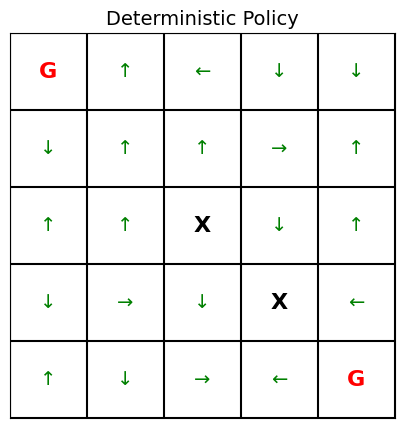

In [3]:
# Create environment
env = GridWorld(height=5, width=5, start=(0, 3), goals=[(4, 4),(0,0)], 
        obstacles=[(2, 2),(3,3)])

# Random stochastic policy
stochastic_policy = env.random_policy()

# Convert to deterministic
policy, rewards = env.deterministic_policy(stochastic_policy)

# Show the arrows of the policy
env.visualise_policy(policy, title="Deterministic Policy")


# nn Q-LEARNING

In [9]:
env = GridWorld(
    height=10,
    width=10,
    start=(0, 0),
    goals=[(4, 4)],
    obstacles=[(5, 8),(3,2)],
    step_penalty=-0.1,
    goal_reward=10,
    obstacle_reward=-5,
    gamma=0.9,
    goal_dynamic=True,      # Goals move randomly!
    obstacle_dynamic=False,
    n_dynamic_goals=1
)


Training Neural Network Q-Learning...
Episode 0/1000 | Avg Reward: -10.00 | Epsilon: 0.298
Episode 50/1000 | Avg Reward: -6.39 | Epsilon: 0.232
Episode 100/1000 | Avg Reward: -6.79 | Epsilon: 0.181
Episode 150/1000 | Avg Reward: -7.47 | Epsilon: 0.141
Episode 200/1000 | Avg Reward: -7.96 | Epsilon: 0.110
Episode 250/1000 | Avg Reward: -8.82 | Epsilon: 0.085
Episode 300/1000 | Avg Reward: -9.30 | Epsilon: 0.066
Episode 350/1000 | Avg Reward: -8.89 | Epsilon: 0.052
Episode 400/1000 | Avg Reward: -8.57 | Epsilon: 0.050
Episode 450/1000 | Avg Reward: -8.88 | Epsilon: 0.050
Episode 500/1000 | Avg Reward: -9.01 | Epsilon: 0.050
Episode 550/1000 | Avg Reward: -9.40 | Epsilon: 0.050
Episode 600/1000 | Avg Reward: -9.66 | Epsilon: 0.050
Episode 650/1000 | Avg Reward: -8.92 | Epsilon: 0.050
Episode 700/1000 | Avg Reward: -7.82 | Epsilon: 0.050
Episode 750/1000 | Avg Reward: -7.64 | Epsilon: 0.050
Episode 800/1000 | Avg Reward: -7.17 | Epsilon: 0.050
Episode 850/1000 | Avg Reward: -6.58 | Epsilo

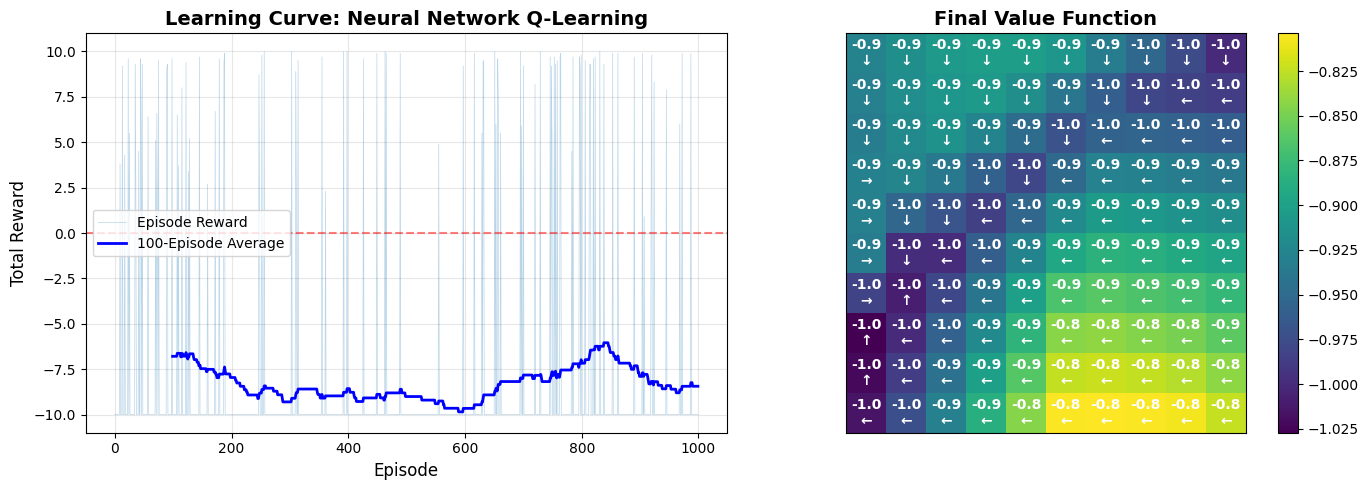


Average reward (last 100 episodes): -8.44
Max reward achieved: 10.00
Final value function saved to 'nn_q_learning_results.png'
GIF saved as nn_learning_dynamic_goals.gif

TESTING LEARNED POLICY

Testing with goal at: (1, 4)
Episode length: 51 steps
Final reward: -0.99
Reached goal: False


In [6]:


# Train neural network Q-learning
print("\nTraining Neural Network Q-Learning...")

q_network, history, reward_history = env.nn_q_learning(
    episodes=1000,
    alpha=0.001,
    epsilon=0.3,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    hidden_sizes=[128, 64],
    record_every=50,
    verbose=True,
    seed=42
)

# Visualize results
print("\n" + "=" * 60)
print("RESULTS")
print("=" * 60)

# Plot final reward curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Reward over time
ax1.plot(reward_history, alpha=0.3, linewidth=0.5, label='Episode Reward')
window = 100
if len(reward_history) > window:
    smoothed = np.convolve(reward_history, np.ones(window)/window, mode='valid')
    ax1.plot(range(window-1, len(reward_history)), smoothed, 'b-', 
            linewidth=2, label=f'{window}-Episode Average')
ax1.set_xlabel("Episode", fontsize=12)
ax1.set_ylabel("Total Reward", fontsize=12)
ax1.set_title("Learning Curve: Neural Network Q-Learning", fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax1.legend()

# Final policy visualization
V_final, policy_final, _ = history[-1]
V_matrix = np.array([V_final[s] for s in range(env.height * env.width)]).reshape(env.height, env.width)

im = ax2.imshow(V_matrix, cmap="viridis", origin="upper")
ax2.set_title("Final Value Function", fontsize=14, fontweight='bold')
for r in range(env.height):
    for c in range(env.width):
        s = env.state_index(r, c)
        # Show value and policy arrow
        arrow = env.ACTION_ARROWS.get(policy_final[s], "")
        ax2.text(c, r, f"{V_matrix[r, c]:.1f}\n{arrow}", 
                ha="center", va="center", color="white", 
                fontsize=10, fontweight='bold')
ax2.set_xticks([])
ax2.set_yticks([])
plt.colorbar(im, ax=ax2)

plt.tight_layout()
plt.savefig("nn_q_learning_results.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAverage reward (last 100 episodes): {np.mean(reward_history[-100:]):.2f}")
print(f"Max reward achieved: {max(reward_history):.2f}")
print(f"Final value function saved to 'nn_q_learning_results.png'")

# Create learning animation
env.visualize_nn_learning(history, reward_history, 
                          gif_name="nn_learning_dynamic_goals.gif", 
                          interval=200)

# Test the learned policy on a new episode
print("\n" + "=" * 60)
print("TESTING LEARNED POLICY")
print("=" * 60)

# Convert network output to policy format for visualization
def network_to_policy(network, env):
    policy = {}
    for s in range(env.height * env.width):
        row, col = env.state_coords(s)
        pos = [row / env.height, col / env.width]
        goal_grid = np.zeros(env.height * env.width)
        for gr, gc in env.goals:
            goal_grid[env.state_index(gr, gc)] = 1.0
        obstacle_grid = np.zeros(env.height * env.width)
        for or_, oc in env.obstacles:
            obstacle_grid[env.state_index(or_, oc)] = 1.0
        state_vector = torch.FloatTensor(np.concatenate([pos, goal_grid, obstacle_grid]))
        
        with torch.no_grad():
            q_values = network(state_vector)
            best_action = q_values.argmax().item()
        
        policy[s] = {a: 1.0 if a == best_action else 0.0 for a in env.ACTIONS}
    return policy

# Test with a new random goal position
env.goals = [(np.random.randint(0, env.height), np.random.randint(0, env.width))]
print(f"\nTesting with goal at: {env.goals[0]}")
policy = network_to_policy(q_network, env)
trajectory, rewards = env.run_episode(policy, max_steps=50)

print(f"Episode length: {len(trajectory)} steps")
print(f"Final reward: {rewards[-1]:.2f}")
print(f"Reached goal: {env.state_coords(trajectory[-1]) in env.goals}")



# Naive DQN

In [7]:
# Train naive DQN
q_network, history, rewards = env.naive_dqn(
    episodes=1000,
    alpha=0.001,
    epsilon=0.1,
    hidden_sizes=[128, 64]
)

# Visualize with the existing visualization method
env.visualize_dqn_learning(history, rewards, "naive_dqn.gif")

Episode 0/1000 | Avg Reward: -10.00 | Epsilon: 0.100
Episode 50/1000 | Avg Reward: -5.40 | Epsilon: 0.077
Episode 100/1000 | Avg Reward: -6.44 | Epsilon: 0.060
Episode 150/1000 | Avg Reward: -8.39 | Epsilon: 0.047
Episode 200/1000 | Avg Reward: -8.98 | Epsilon: 0.037
Episode 250/1000 | Avg Reward: -8.47 | Epsilon: 0.028
Episode 300/1000 | Avg Reward: -7.99 | Epsilon: 0.022
Episode 350/1000 | Avg Reward: -7.55 | Epsilon: 0.017
Episode 400/1000 | Avg Reward: -7.90 | Epsilon: 0.013
Episode 450/1000 | Avg Reward: -9.04 | Epsilon: 0.010
Episode 500/1000 | Avg Reward: -8.81 | Epsilon: 0.010
Episode 550/1000 | Avg Reward: -8.81 | Epsilon: 0.010
Episode 600/1000 | Avg Reward: -8.46 | Epsilon: 0.010
Episode 650/1000 | Avg Reward: -6.79 | Epsilon: 0.010
Episode 700/1000 | Avg Reward: -7.55 | Epsilon: 0.010
Episode 750/1000 | Avg Reward: -8.44 | Epsilon: 0.010
Episode 800/1000 | Avg Reward: -7.85 | Epsilon: 0.010
Episode 850/1000 | Avg Reward: -7.84 | Epsilon: 0.010
Episode 900/1000 | Avg Reward:

# DQN

In [10]:
# Train with DQN
q_network, history, reward_history = env.dqn(
    episodes=1000,
    alpha=0.001,
    epsilon=0.3,
    epsilon_decay=0.995,
    batch_size=32,
    buffer_size=10000,
    target_update_freq=10,  # Update target network every 10 episodes
    hidden_sizes=[128, 64],
    record_every=50,
    verbose=True,
    seed=42
)

# Visualize the learning process
env.visualize_dqn_learning(history, reward_history, 
                           gif_name="dqn_dynamic_goals.gif")

Episode 0/1000 | Avg Reward: -10.00 | Epsilon: 0.298 | Buffer: 100
Episode 50/1000 | Avg Reward: -3.94 | Epsilon: 0.232 | Buffer: 3929
Episode 100/1000 | Avg Reward: -5.35 | Epsilon: 0.181 | Buffer: 8377
Episode 150/1000 | Avg Reward: -5.99 | Epsilon: 0.141 | Buffer: 10000
Episode 200/1000 | Avg Reward: -5.32 | Epsilon: 0.110 | Buffer: 10000
Episode 250/1000 | Avg Reward: -5.25 | Epsilon: 0.085 | Buffer: 10000
Episode 300/1000 | Avg Reward: -6.13 | Epsilon: 0.066 | Buffer: 10000
Episode 350/1000 | Avg Reward: -6.77 | Epsilon: 0.052 | Buffer: 10000
Episode 400/1000 | Avg Reward: -7.33 | Epsilon: 0.040 | Buffer: 10000
Episode 450/1000 | Avg Reward: -8.43 | Epsilon: 0.031 | Buffer: 10000
Episode 500/1000 | Avg Reward: -8.55 | Epsilon: 0.024 | Buffer: 10000
Episode 550/1000 | Avg Reward: -8.02 | Epsilon: 0.019 | Buffer: 10000
Episode 600/1000 | Avg Reward: -6.97 | Epsilon: 0.015 | Buffer: 10000
Episode 650/1000 | Avg Reward: -7.54 | Epsilon: 0.011 | Buffer: 10000
Episode 700/1000 | Avg Rew